In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
def ResNet18():
    return ResNet(ResidualBlock)

In [6]:
#Use the ResNet18 on MNIST
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os

#check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#set hyperparameter
EPOCH = 4
BATCH_SIZE = 128
LR = 0.01
PATIENCE = 3  # Early stopping patience (number of epochs without improvement)

# Initialize variables for early stopping
best_val_loss = float('inf')
epochs_without_improvement = 0

# MNIST dataset and transformations one for both train and test
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST Train Data
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Load MNIST Test Data
testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# ResNet18 Definition
net = ResNet18().to(device)

#loss funtion & optimizer definition
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)

# lists for diagnostic plots
train_losses = []
train_accuracies = []
test_accuracies = []


Epoch: 1
[Epoch 1, Iteration 100] Loss: 0.000 | Acc: 100.000%
[Epoch 1, Iteration 200] Loss: 0.000 | Acc: 100.000%
[Epoch 1, Iteration 300] Loss: 0.000 | Acc: 100.000%
[Epoch 1, Iteration 400] Loss: 0.000 | Acc: 100.000%
Waiting Test...
Test Accuracy: 99.570% | Validation Loss: 0.013

Epoch: 2
[Epoch 2, Iteration 100] Loss: 0.000 | Acc: 100.000%
[Epoch 2, Iteration 200] Loss: 0.000 | Acc: 100.000%
[Epoch 2, Iteration 300] Loss: 0.000 | Acc: 100.000%
[Epoch 2, Iteration 400] Loss: 0.000 | Acc: 100.000%
Waiting Test...
Test Accuracy: 99.550% | Validation Loss: 0.014

Epoch: 3
[Epoch 3, Iteration 100] Loss: 0.000 | Acc: 100.000%
[Epoch 3, Iteration 200] Loss: 0.000 | Acc: 100.000%
[Epoch 3, Iteration 300] Loss: 0.000 | Acc: 100.000%
[Epoch 3, Iteration 400] Loss: 0.000 | Acc: 100.000%
Waiting Test...
Test Accuracy: 99.560% | Validation Loss: 0.014

Epoch: 4
[Epoch 4, Iteration 100] Loss: 0.000 | Acc: 100.000%
[Epoch 4, Iteration 200] Loss: 0.000 | Acc: 100.000%
[Epoch 4, Iteration 300] L

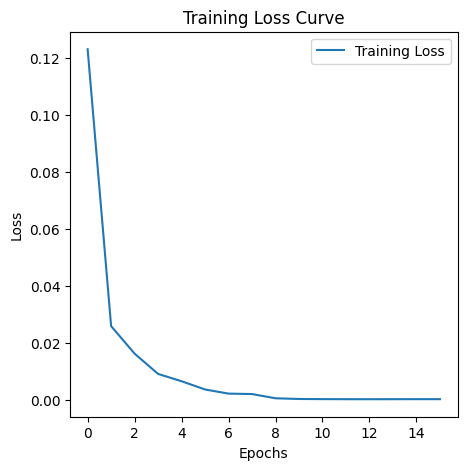

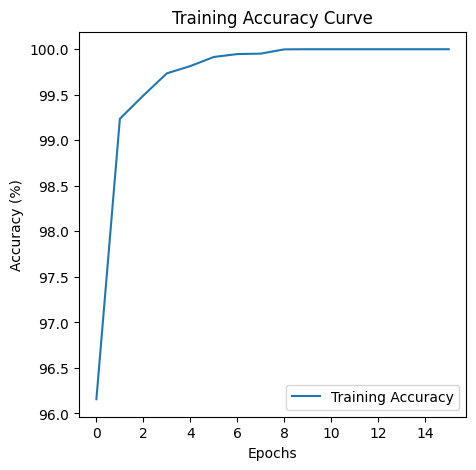

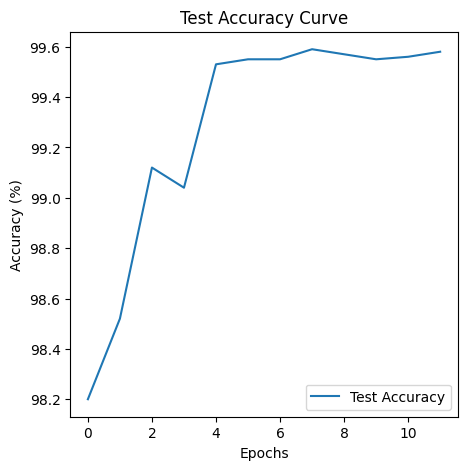

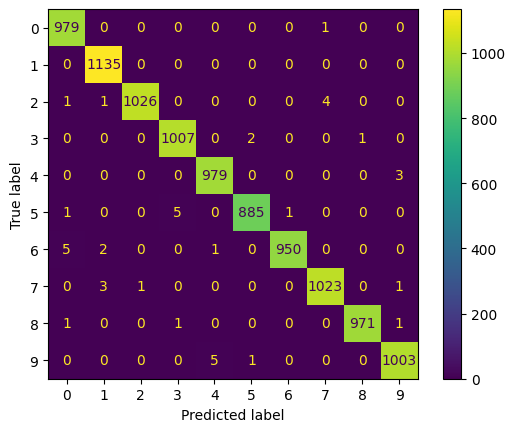

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.99      1.00      1032
           3       0.99      1.00      1.00      1010
           4       0.99      1.00      1.00       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      1.00       958
           7       1.00      1.00      1.00      1028
           8       1.00      1.00      1.00       974
           9       1.00      0.99      0.99      1009

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [11]:
# Initialize early stopping variables
best_val_loss = float('inf')  # Start with a large number
epochs_without_improvement = 0
PATIENCE = 3  # Number of epochs to wait for improvement before stopping

# Training loop
for epoch in range(EPOCH):
    print(f'\nEpoch: {epoch + 1}')
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward & backward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print loss and accuracy in each batch
        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        if i % 100 == 99:  # Print every 100 batches
            print(f'[Epoch {epoch + 1}, Iteration {i + 1}] Loss: {sum_loss / (i + 1):.03f} | Acc: {100. * correct / total:.3f}%')

    # Record training loss and accuracy
    train_losses.append(sum_loss / len(trainloader))
    train_accuracies.append(100. * correct / total)

    # Validation (Test set) phase
    print('Waiting Test...')
    net.eval()  # Switch to evaluation mode
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()

    # Calculate average validation loss
    avg_val_loss = val_loss / len(testloader)
    test_accuracy = 100 * correct.cpu() / total
    test_accuracies.append(test_accuracy)

    print(f'Test Accuracy: {test_accuracy:.3f}% | Validation Loss: {avg_val_loss:.3f}')

    # Early stopping condition
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset the counter if the loss improves
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= PATIENCE:
            print(f"Early stopping at epoch {epoch + 1} due to no improvement in validation loss.")
            break  # Stop training if no improvement for 'patience' epochs

print(f'Training complete. Total epochs: {epoch + 1}')

# Plotting
epochs = len(train_losses)

# 1. Training Loss Curve
plt.figure(figsize=(5, 5))
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

# 2. Training Accuracy Curve
plt.figure(figsize=(5, 5))
plt.plot(range(epochs), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Curve')
plt.legend()
plt.show()

test_epochs = len(test_accuracies)

# 3. Test Accuracy Curve
plt.figure(figsize=(5, 5))
plt.plot(range(test_epochs), [acc.cpu().item() for acc in test_accuracies], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve')
plt.legend()
plt.show()

# 4. Confusion Matrix for Test Data
y_true = []
y_pred = []

# Collect true labels and predictions
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.show()

# 5. Classification Report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_true, y_pred))
